# Τεχνικές Εξόρυξης Δεδομένων
### Εργασία 2, Εαρινό Εξάμηνο 2021

**Θεμιστοκλής Σωτηρόπουλος 1115201400197**

**Δημήτριος Μπέρος 1115201600269**

*Προετοιμασία*

In [1]:
!pip install --upgrade gensim
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import pandas as pd
import random
import numpy as np
import re
import random
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from google.colab import drive
import nltk
from nltk.corpus import stopwords
from gensim.models import Word2Vec
import gensim.downloader as api
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
nltk.download('stopwords')
drive.mount('/content/gdrive',force_remount=True)

     |████████████████████████████████| 23.9MB 166kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Mounted at /content/gdrive


*Διάβασμα αρχείου Fake*

In [2]:
fake=pd.read_csv('/content/gdrive/MyDrive/DataMining/Project2/NewsDataset/Fake.csv')
fake.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


*Διάβασμα αρχείου True*

In [3]:
true=pd.read_csv('/content/gdrive/MyDrive/DataMining/Project2/NewsDataset/True.csv')
true.head(5)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


**1. Προεπεξεργασία/ Καθάρισμα**

In [4]:
fakeNN=fake.dropna()
trueNN=true.dropna()

**2.  Μελέτη των δεδομένων.**

*α. Ο τίτλος καθορίζει αρκετά το περιεχόμενο ενός άρθρου. Προσπαθήστε να
οπτικοποιήστε τους τίτλους των fake και των non-fake news έτσι ώστε να μπορεί
κάποιος να εντοπίσει τα κεντρικά θέματα τα οποία διαπραγματεύονται τα άρθρα.*

*Παίρνουμε από τα Dataframes των Fake και True, τις στήλες με τους τίτλους. Χωρίζουμε τους τίτλους ανά λέξη και αφαιρούμε τα stopwords, τα σημεία στίξης και σύμβολα και τους αποθηκεύουμε σε λίστα από λίστες.*

In [5]:
fakeTitles = fakeNN['title']
trueTitles = trueNN['title']

fakeTokens = [title.lower().split() for title in fakeTitles]
trueTokens = [title.lower().split() for title in trueTitles]


stop_words = list(stopwords.words('english'))

fakeTokens2 = []
trueTokens2 = []

for i in range(len(fakeTokens)):
    temp = []
    for word in fakeTokens[i]:
        if word not in stop_words:
            word = re.sub(r"[^\w'.\s]", '', word)
            if len(word) > 1:
                temp.append(word)
    fakeTokens2.append(temp)


for i in range(len(trueTokens)):
    temp = []
    for word in trueTokens[i]:
        if word not in stop_words:
            word = re.sub(r"[^\w'.\s]", '', word)
            if len(word) > 1:
                temp.append(word)
    trueTokens2.append(temp)

*Με βάση τις παραπάνω λίστες δημιουργούμε δύο μοντέλα word2vec, χτίζουμε το λεξιλόγιο τους και τα κάνουμε train.*

In [6]:
w2vmodelFake = Word2Vec(fakeTokens2,vector_size=50,seed=32,
    negative=5,sg=0,min_count=1,window=1)

w2vmodelFake.build_vocab(fakeTokens2)  # prepare the model vocabulary

w2vmodelFake.train(fakeTokens2, total_examples=w2vmodelFake.corpus_count, epochs=5); # train the model

w2vmodelTrue = Word2Vec(trueTokens2,vector_size=50,seed=32,
    negative=5,sg=0,min_count=1,window=1)

w2vmodelTrue.build_vocab(trueTokens2)  # prepare the model vocabulary

w2vmodelTrue.train(trueTokens2, total_examples=w2vmodelTrue.corpus_count, epochs=5); # train the model

*Την παρακάτω συνάρτηση την έχουμε πάρει από το Notebook Small_Word_Embeddings_with_Gensim των σημειώσεων του μαθήματος. Κάναμε μερικές τροποποιήσεις έτσι ώστε να λειτουργεί σωστά με την ενημερωμένη έκδοση του word2vec καθώς και με τα δεδομένα μας.*

In [7]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.wv.index_to_key), sample)
        else:
            words = [ word for word in model.wv.index_to_key]
        
    word_vectors = np.array([model.wv[w] for w in words])
    print(word_vectors.shape)

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(20,20))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)
    plt.show()

*Στη λίστα που είναι αποθηκευμένο το λεξιλόγιο του κάθε μοντέλου, εμφανίζονται με φθίνουσα σειρά οι πιο συχνά εμφανιζόμενες λέξεις. Για λόγους αποδοτικότητας και πολυπλοκότητας του αλγορίθμου, επιλέξαμε να εμφανίσουμε τις Top 500 από τις οποίες αφαιρέσαμε τις διπλότυπες.*

In [8]:
tempFake = w2vmodelFake.wv.index_to_key[:500]
topFake = list(dict.fromkeys(tempFake))

In [9]:
tempTrue = w2vmodelTrue.wv.index_to_key[:500]
topTrue = list(dict.fromkeys(tempTrue))

*Και για τις δύο κατηγορίες άρθρων, φτιάχνουμε μία λίστα από tuples με πρώτη τιμή τη λέξη και δεύτερη τιμ΄ή τα Vectors των τιμών τους στο μοντέλο*

In [18]:
vlistFake = []
words_filter_fake = []

for word in topFake:
        if word in w2vmodelFake.wv.index_to_key:
            vlistFake.append(w2vmodelFake.wv[word])
            words_filter_fake.append(word)

word_vec_zip_fake = list(zip(words_filter_fake, vlistFake))

In [19]:
vlistTrue = []
words_filter_true = []

for word in topTrue:
        if word in w2vmodelTrue.wv.index_to_key:
            vlistTrue.append(w2vmodelTrue.wv[word])
            words_filter_true.append(word)

word_vec_zip_true = list(zip(words_filter_true, vlistTrue))

*Δημιουργούμε Dataframes με τις λίστες αυτές*

In [20]:
dfFake = pd.DataFrame(data = word_vec_zip_fake, columns=['word', 'value'])
dfTrue = pd.DataFrame(data = word_vec_zip_true, columns=['word', 'value'])

In [21]:

# def tsne_plot(model):
#     "Creates and TSNE model and plots it"
#     labels = []
#     tokens = []
#     for word in model.wv.index_to_key:
#         #new = model.wv[word].reshape(-1,2)
#         print(word)
#         tokens.append(model.wv[word])
#         labels.append(word)
#         tsne_model = TSNE(perplexity=40, n_components=1, init='pca', n_iter=2500, random_state=23)
#         new_values = tsne_model.fit_transform(tokens)

#     x = []
#     y = []

#     for value in new_values:
#         x.append(value[0])
#         y.append(value[1])


#     plt.figure(figsize=(16, 16))

#     for i in range(len(x)):
#         plt.scatter(x[i],y[i])
#         plt.annotate(labels[i], xy=(x[i], y[i]), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    
#     plt.show()

*Εμφάνιση αποτελεσμάτων για τα Fake news.*

(500, 50)


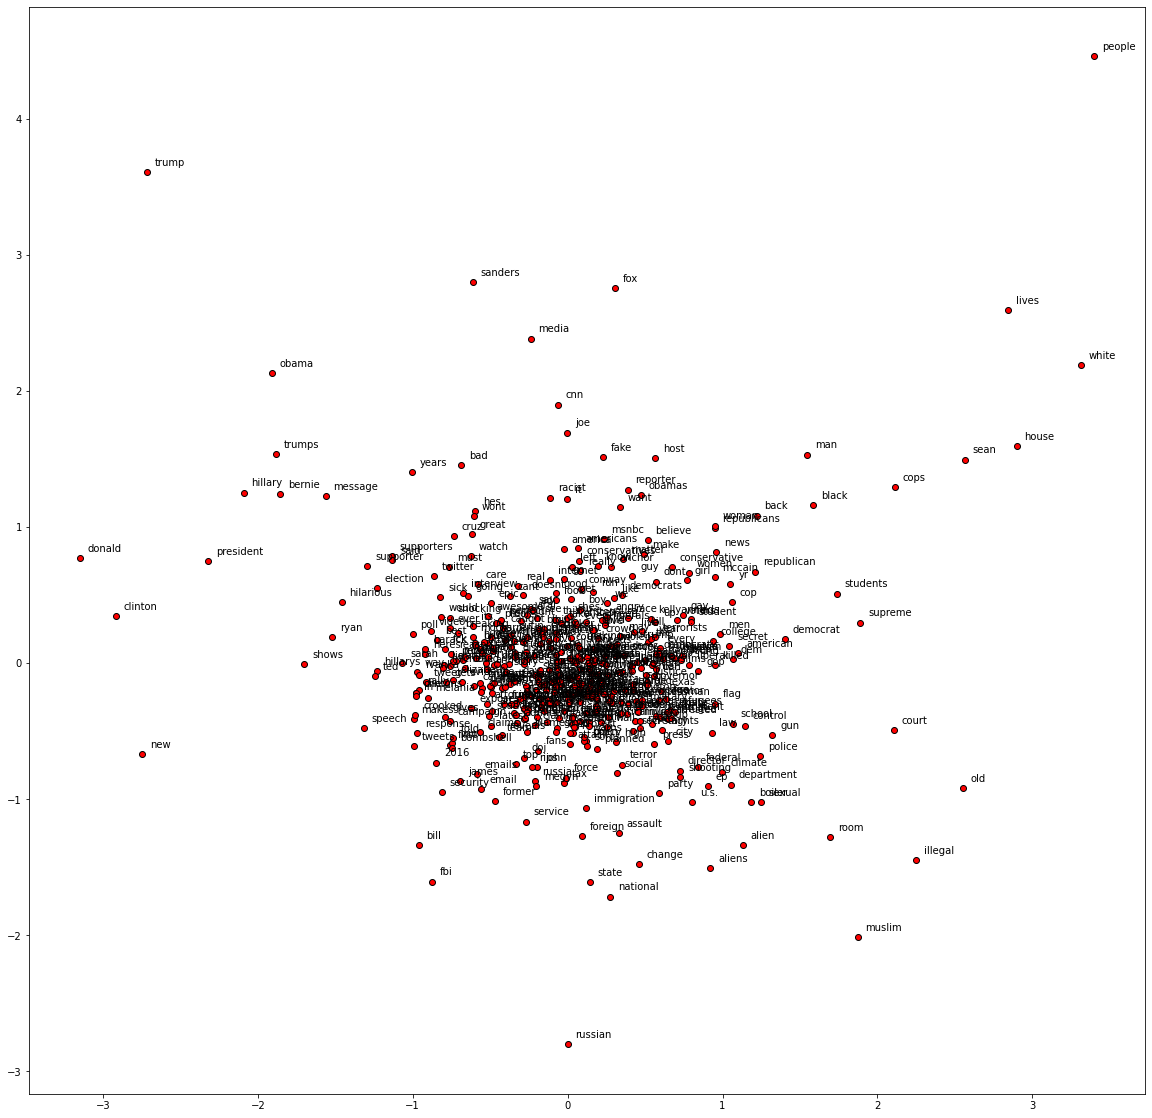

In [22]:
wFake = dfFake['word']wFake = dfFake['word']
words = [w for w in wFake]
  
display_pca_scatterplot(w2vmodelFake, words)

*Εμφάνιση αποτελεσμάτων για True*

(500, 50)


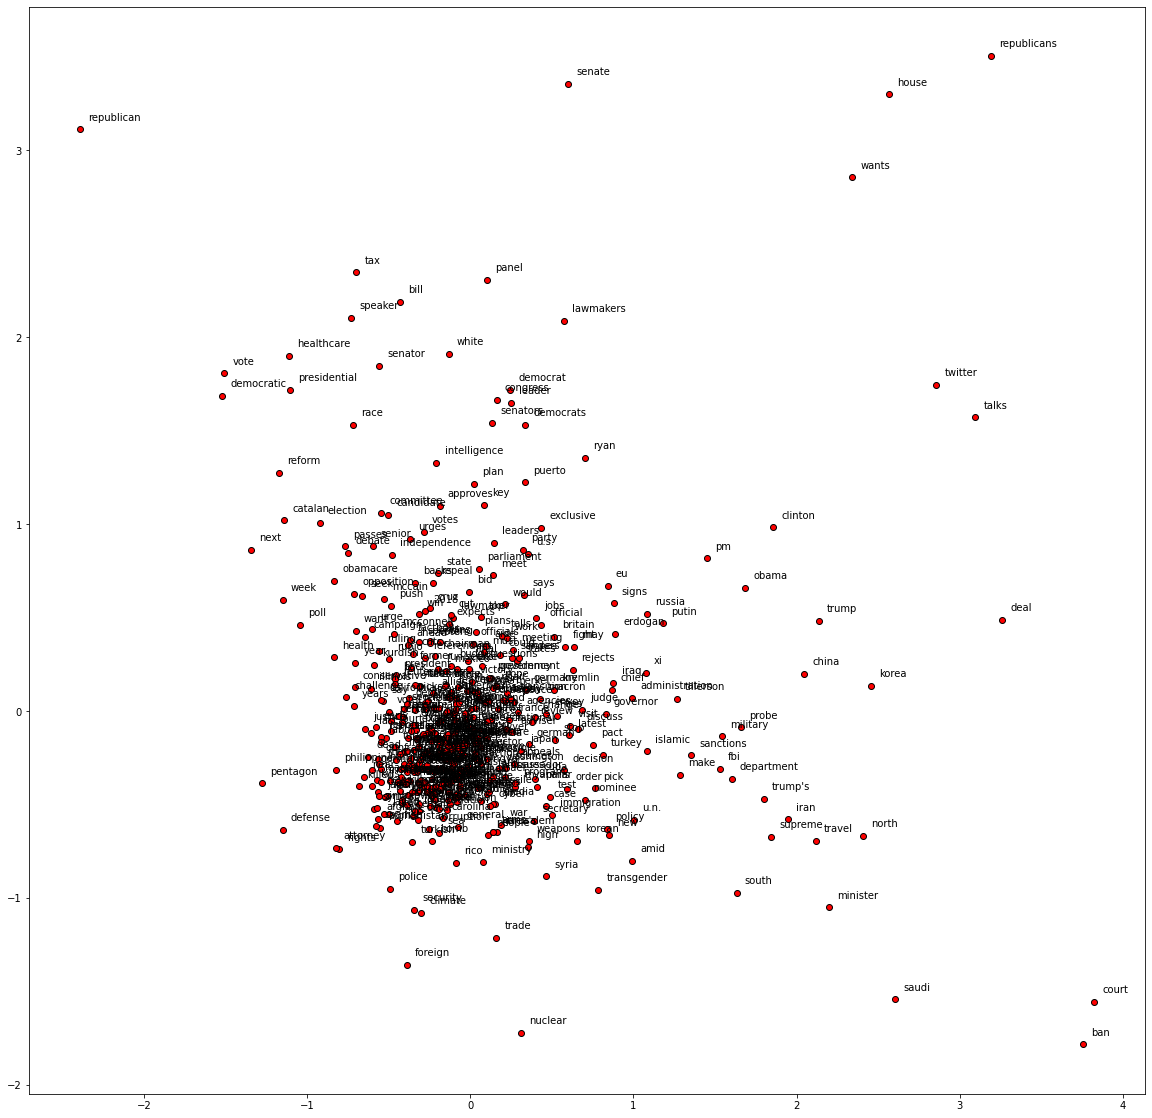

In [23]:
wTrue = dfTrue['word']
words = [w for w in wTrue]
  
display_pca_scatterplot(w2vmodelTrue, words)

*Ως δεύτερη και πιο εμφανίσιμη οπτικοποίηση, δημιουργήσαμε wordclouds και για τις δύο κατηγορίες*

*Fake*

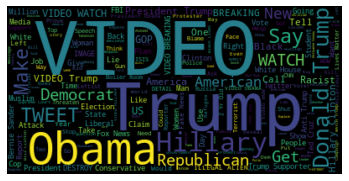

In [24]:
text = " ".join(n for n in fakeNN['title'])
wordcloud = WordCloud(stopwords=stop_words).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

*True*

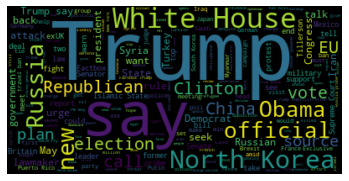

In [25]:
text2 = " ".join(n for n in trueNN['title'])
wordcloud2 = WordCloud(stopwords=stop_words).generate(text2)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")

plt.show()

Μέσος όρος χαρακτήρων στους τίτλους των Fake: 4470.688
Μέσος όρος χαρακτήρων στους τίτλους των True: 2812.816


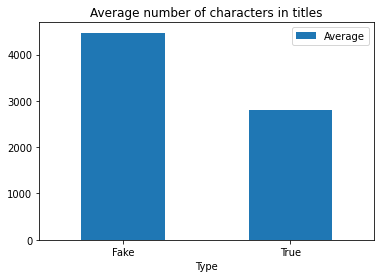

In [26]:
avgChar = len(text) / len(dfFake.index)
avgChar2 = len(text2) / len(dfTrue.index)

print("Μέσος όρος χαρακτήρων στους τίτλους των Fake:", avgChar)
print("Μέσος όρος χαρακτήρων στους τίτλους των True:", avgChar2)

avgDict = {'Fake': avgChar, 'True': avgChar2}
avgDF = pd.DataFrame.from_dict(avgDict, orient='index', columns=['Average'])

avgDF.plot.bar(rot=0)
plt.xlabel('Type')
plt.title('Average number of characters in titles')
plt.show()

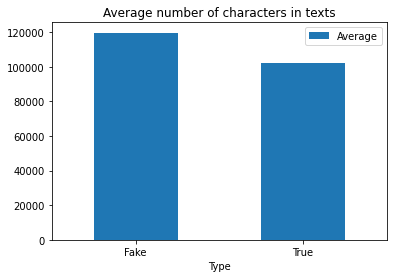

In [27]:
allTextsFake = " ".join(n for n in fakeNN['text'])
allTextsTrue = " ".join(n for n in trueNN['text'])

avgTextFake = len(allTextsFake) / len(dfFake.index)
avgTextTrue = len(allTextsTrue) / len(dfTrue.index)

avgText = {'Fake': avgTextFake, 'True': avgTextTrue}

avgTextDF = pd.DataFrame.from_dict(avgText, orient='index', columns=['Average'])

avgTextDF.plot.bar(rot=0)
plt.xlabel('Type')
plt.title('Average number of characters in texts')
plt.show()

*γ. Σχεδιάστε την κατανομή του αριθμού των λέξεων για τη στήλη title και για τη στήλη
text (και για τα δύο αρχεία)*

*Δημιουργία Συνάρτησης count_words*

In [59]:
def count_words(fname):
    d = {}
    for line in fname:
        words = line.strip().split()
        for word in words:
            try:
                d[word] += 1
            except KeyError:
                d[word] = 1
    return d

*Για το αρχείο Fake*

*Για στήλη title*

In [60]:
fake_title = fakeNN['title']
count_words(fake_title)

{'Donald': 724,
 'Trump': 5798,
 'Sends': 43,
 'Out': 733,
 'Embarrassing': 45,
 'New': 641,
 'Year’s': 12,
 'Eve': 13,
 'Message;': 1,
 'This': 821,
 'is': 385,
 'Disturbing': 33,
 'Drunk': 15,
 'Bragging': 23,
 'Staffer': 32,
 'Started': 23,
 'Russian': 230,
 'Collusion': 41,
 'Investigation': 121,
 'Sheriff': 48,
 'David': 40,
 'Clarke': 3,
 'Becomes': 26,
 'An': 302,
 'Internet': 108,
 'Joke': 32,
 'For': 3948,
 'Threatening': 49,
 'To': 7539,
 'Poke': 2,
 'People': 330,
 '‘In': 5,
 'The': 4325,
 'Eye’': 2,
 'Is': 2037,
 'So': 237,
 'Obsessed': 8,
 'He': 982,
 'Even': 154,
 'Has': 594,
 'Obama’s': 395,
 'Name': 63,
 'Coded': 1,
 'Into': 333,
 'His': 1521,
 'Website': 28,
 '(IMAGES)': 130,
 'Pope': 32,
 'Francis': 15,
 'Just': 1183,
 'Called': 125,
 'During': 429,
 'Christmas': 47,
 'Speech': 282,
 'Racist': 299,
 'Alabama': 30,
 'Cops': 164,
 'Brutalize': 2,
 'Black': 571,
 'Boy': 61,
 'While': 250,
 'In': 3502,
 'Handcuffs': 5,
 '(GRAPHIC': 1,
 'IMAGES)': 2,
 'Fresh': 1,
 'Off': 2

*Για στήλη text*

In [61]:
fake_text = fakeNN['text']
count_words(fake_text)

{'Donald': 16751,
 'Trump': 64844,
 'just': 18557,
 'couldn': 1495,
 't': 39421,
 'wish': 535,
 'all': 20336,
 'Americans': 5070,
 'a': 202870,
 'Happy': 115,
 'New': 6756,
 'Year': 381,
 'and': 213059,
 'leave': 1298,
 'it': 53935,
 'at': 38276,
 'that.': 1583,
 'Instead,': 539,
 'he': 62175,
 'had': 20047,
 'to': 286028,
 'give': 3058,
 'shout': 58,
 'out': 20219,
 'his': 55840,
 'enemies,': 54,
 'haters': 66,
 'the': 483203,
 'very': 8631,
 'dishonest': 201,
 'fake': 2214,
 'news': 4867,
 'media.': 556,
 'The': 40127,
 'former': 6454,
 'reality': 1293,
 'show': 4218,
 'star': 698,
 'one': 19037,
 'job': 2087,
 'do': 12847,
 'it.': 4166,
 'As': 3839,
 'our': 18188,
 'Country': 69,
 'rapidly': 147,
 'grows': 46,
 'stronger': 201,
 'smarter,': 15,
 'I': 42453,
 'want': 6908,
 'of': 233193,
 'my': 7737,
 'friends,': 195,
 'supporters,': 318,
 'haters,': 17,
 'even': 12388,
 'Fake': 342,
 'News': 6075,
 'Media,': 32,
 'Healthy': 18,
 'Year,': 44,
 'President': 15191,
 'Angry': 26,
 'Pant

*Για το αρχείο True*

*Για στήλη title*

In [62]:
true_title = trueNN['title']
count_words(true_title)

{'As': 64,
 'U.S.': 3872,
 'budget': 217,
 'fight': 202,
 'looms,': 6,
 'Republicans': 311,
 'flip': 1,
 'their': 31,
 'fiscal': 26,
 'script': 2,
 'military': 301,
 'to': 7794,
 'accept': 30,
 'transgender': 60,
 'recruits': 5,
 'on': 3315,
 'Monday:': 13,
 'Pentagon': 94,
 'Senior': 42,
 'Republican': 624,
 'senator:': 7,
 "'Let": 2,
 'Mr.': 2,
 'Mueller': 28,
 'do': 44,
 'his': 196,
 "job'": 3,
 'FBI': 161,
 'Russia': 718,
 'probe': 309,
 'helped': 19,
 'by': 585,
 'Australian': 62,
 'diplomat': 46,
 'tip-off:': 1,
 'NYT': 36,
 'Trump': 4400,
 'wants': 201,
 'Postal': 1,
 'Service': 15,
 'charge': 45,
 "'much": 1,
 "more'": 3,
 'for': 2745,
 'Amazon': 6,
 'shipments': 5,
 'White': 788,
 'House,': 19,
 'Congress': 311,
 'prepare': 15,
 'talks': 453,
 'spending,': 5,
 'immigration': 149,
 'says': 2969,
 'will': 702,
 'be': 490,
 'fair,': 5,
 'but': 241,
 'timeline': 2,
 'unclear:': 1,
 'Factbox:': 407,
 'Twitter': 152,
 '(Dec': 13,
 '29)': 2,
 '-': 354,
 'Approval': 3,
 'rating,': 1,


*Για στήλη Text*

In [63]:
true_text = trueNN['text']
count_words(true_text)

{'WASHINGTON': 6503,
 '(Reuters)': 21239,
 '-': 31059,
 'The': 55109,
 'head': 2644,
 'of': 204339,
 'a': 187214,
 'conservative': 2519,
 'Republican': 14487,
 'faction': 134,
 'in': 169538,
 'the': 422622,
 'U.S.': 38271,
 'Congress,': 714,
 'who': 27242,
 'voted': 1394,
 'this': 16062,
 'month': 3084,
 'for': 77867,
 'huge': 515,
 'expansion': 347,
 'national': 4391,
 'debt': 1269,
 'to': 243787,
 'pay': 1927,
 'tax': 7136,
 'cuts,': 129,
 'called': 6004,
 'himself': 1214,
 '“fiscal': 7,
 'conservative”': 4,
 'on': 104807,
 'Sunday': 2264,
 'and': 179411,
 'urged': 1716,
 'budget': 2639,
 'restraint': 78,
 '2018.': 347,
 'In': 9916,
 'keeping': 487,
 'with': 53018,
 'sharp': 314,
 'pivot': 44,
 'under': 7004,
 'way': 2973,
 'among': 3306,
 'Republicans,': 606,
 'Representative': 1642,
 'Mark': 613,
 'Meadows,': 48,
 'speaking': 1142,
 'CBS’': 40,
 '“Face': 62,
 'Nation,”': 9,
 'drew': 577,
 'hard': 1254,
 'line': 1222,
 'federal': 5110,
 'spending,': 179,
 'which': 20691,
 'lawmakers

*δ. Επαναλλάβετε το προηγούμενο ερώτημα αφαιρώντας τα stopwords.*

*Για το αρχείο Fake*

*Για τη στήλη title*

In [126]:
nstop_fake_title = fakeNN['title']
d = {}
d=count_words(nstop_fake_title)
for i in d.keys():
    if i in fakeTokens2:
        del d[i]
print(d)

{'Donald': 724, 'Trump': 5798, 'Sends': 43, 'Out': 733, 'Embarrassing': 45, 'New': 641, 'Year’s': 12, 'Eve': 13, 'Message;': 1, 'This': 821, 'is': 385, 'Disturbing': 33, 'Drunk': 15, 'Bragging': 23, 'Staffer': 32, 'Started': 23, 'Russian': 230, 'Collusion': 41, 'Investigation': 121, 'Sheriff': 48, 'David': 40, 'Clarke': 3, 'Becomes': 26, 'An': 302, 'Internet': 108, 'Joke': 32, 'For': 3948, 'Threatening': 49, 'To': 7539, 'Poke': 2, 'People': 330, '‘In': 5, 'The': 4325, 'Eye’': 2, 'Is': 2037, 'So': 237, 'Obsessed': 8, 'He': 982, 'Even': 154, 'Has': 594, 'Obama’s': 395, 'Name': 63, 'Coded': 1, 'Into': 333, 'His': 1521, 'Website': 28, '(IMAGES)': 130, 'Pope': 32, 'Francis': 15, 'Just': 1183, 'Called': 125, 'During': 429, 'Christmas': 47, 'Speech': 282, 'Racist': 299, 'Alabama': 30, 'Cops': 164, 'Brutalize': 2, 'Black': 571, 'Boy': 61, 'While': 250, 'In': 3502, 'Handcuffs': 5, '(GRAPHIC': 1, 'IMAGES)': 2, 'Fresh': 1, 'Off': 298, 'Golf': 43, 'Course,': 2, 'Lashes': 16, 'At': 1117, 'FBI': 369

*Για τη στήλη text*

In [138]:
fakeText = fakeNN['text']
fakeTk = [text.lower().split() for text in fakeText]

stop_words = list(stopwords.words('english'))

faketk2 = []

for i in range(len(fakeTk)):
    temp = []
    for word in fakeTk[i]:
        if word not in stop_words:
            word = re.sub(r"[^\w'.\s]", '', word)
            if len(word) > 1:
                temp.append(word)
    faketk2.append(temp)

nstop_fake_text = fakeNN['text']
d = {}
d=count_words(nstop_fake_text)
for i in d.keys():
    if i in faketk2:
        del d[i]
# print(d)
print(list(d)[:10])

['Donald', 'Trump', 'just', 'couldn', 't', 'wish', 'all', 'Americans', 'a', 'Happy']


*Για το αρχείο True*

*Για τη στήλη title*

In [139]:
nstop_true_title = trueNN['title']
d = {}
d=count_words(nstop_true_title)
for i in d.keys():
    if i in trueTokens2:
        del d[i]
print(d)

{'As': 64, 'U.S.': 3872, 'budget': 217, 'fight': 202, 'looms,': 6, 'Republicans': 311, 'flip': 1, 'their': 31, 'fiscal': 26, 'script': 2, 'military': 301, 'to': 7794, 'accept': 30, 'transgender': 60, 'recruits': 5, 'on': 3315, 'Monday:': 13, 'Pentagon': 94, 'Senior': 42, 'Republican': 624, 'senator:': 7, "'Let": 2, 'Mr.': 2, 'Mueller': 28, 'do': 44, 'his': 196, "job'": 3, 'FBI': 161, 'Russia': 718, 'probe': 309, 'helped': 19, 'by': 585, 'Australian': 62, 'diplomat': 46, 'tip-off:': 1, 'NYT': 36, 'Trump': 4400, 'wants': 201, 'Postal': 1, 'Service': 15, 'charge': 45, "'much": 1, "more'": 3, 'for': 2745, 'Amazon': 6, 'shipments': 5, 'White': 788, 'House,': 19, 'Congress': 311, 'prepare': 15, 'talks': 453, 'spending,': 5, 'immigration': 149, 'says': 2969, 'will': 702, 'be': 490, 'fair,': 5, 'but': 241, 'timeline': 2, 'unclear:': 1, 'Factbox:': 407, 'Twitter': 152, '(Dec': 13, '29)': 2, '-': 354, 'Approval': 3, 'rating,': 1, '28)': 4, 'Global': 4, 'Warming': 1, 'Alabama': 41, 'official': 32

*Για τη στήλη text*

In [141]:
trueText = trueNN['text']
trueTK = [text.lower().split() for text in trueText]

stop_words = list(stopwords.words('english'))

trueTK2 = []

for i in range(len(trueTK)):
    temp = []
    for word in trueTK[i]:
        if word not in stop_words:
            word = re.sub(r"[^\w'.\s]", '', word)
            if len(word) > 1:
                temp.append(word)
    trueTK2.append(temp)

nstop_true_text = trueNN['text']
d = {}
d=count_words(nstop_true_text)
for i in d.keys():
    if i in trueTK2:
        del d[i]
# print(d)
print(list(d)[:10])

['WASHINGTON', '(Reuters)', '-', 'The', 'head', 'of', 'a', 'conservative', 'Republican', 'faction']
